## PROJECT04 Flowers Classification

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

%matplotlib inline
%config inlineBackend.figure_format='retina'


In [2]:
# https://inpages.tistory.com/155
# 필요한 만큼 메모리를 런타임에 할당하는 방법(가장 처음 실행시켜 줄 것)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### 1. 데이터 불러오기 
 - tf_flowers의 80%는 train data, 10%는 validation data, 10%는 test data로 나눈다 

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('tf_flowers',
split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
with_info=True,
as_supervised=True,
)

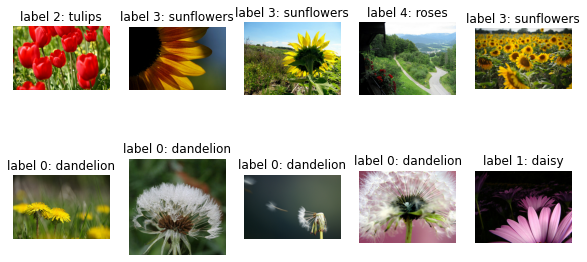

In [4]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

이미지의 크기가 다양하다는 것을 확인할 수 있다. 

In [5]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

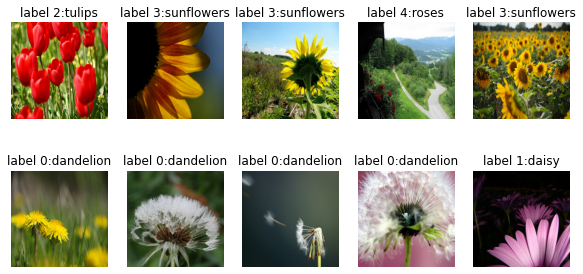

In [7]:
plt.figure(figsize=(10, 5))

get_lable_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image+1) / 2
    plt.imshow(image)
    plt.title(f'label {label}:{get_label_name(label)}')
    plt.axis('off')

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [9]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
metadata

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

### 2. 모델 학습 
####  1) VGG16
  1-1 Convolutional base는  ImageNet으로 학습된 파라미터를 그대로 사용하고 classifier만 새로 학습 시키는 방법

In [46]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [48]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [49]:
base_model.trainable = False

In [50]:
model = tf.keras.Sequential([
    base_model, 
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [51]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [53]:
EPOCHS = 30   
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
92/92 [==============================] - 66s 718ms/step - loss: 1.3642 - accuracy: 0.5027 - val_loss: 1.1530 - val_accuracy: 0.6431
Epoch 2/30
92/92 [==============================] - 7s 76ms/step - loss: 1.0410 - accuracy: 0.6884 - val_loss: 0.9353 - val_accuracy: 0.7030
Epoch 3/30
92/92 [==============================] - 7s 76ms/step - loss: 0.8716 - accuracy: 0.7425 - val_loss: 0.7932 - val_accuracy: 0.7357
Epoch 4/30
92/92 [==============================] - 7s 76ms/step - loss: 0.7692 - accuracy: 0.7643 - val_loss: 0.7293 - val_accuracy: 0.7411
Epoch 5/30
92/92 [==============================] - 8s 84ms/step - loss: 0.7005 - accuracy: 0.7793 - val_loss: 0.6810 - val_accuracy: 0.7657
Epoch 6/30
92/92 [==============================] - 8s 82ms/step - loss: 0.6496 - accuracy: 0.7929 - val_loss: 0.6463 - val_accuracy: 0.7657
Epoch 7/30
92/92 [==============================] - 7s 76ms/step - loss: 0.6123 - accuracy: 0.8031 - val_loss: 0.6064 - val_accuracy: 0.7766
Epoch 8/30


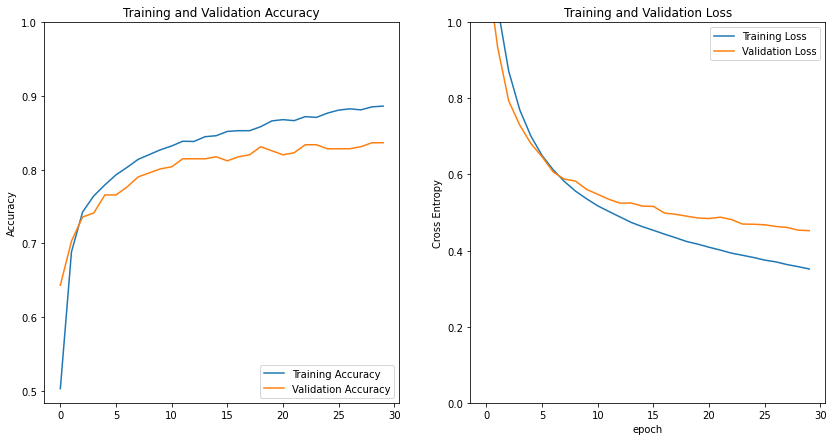

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [55]:
loss0, accuracy0 = model.evaluate(test_batches)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 1s 52ms/step - loss: 0.4283 - accuracy: 0.8474
initial loss: 0.43
initial accuracy: 0.85


위의 결과와 같이 원하는 만큼의 성능이 나오지 않았다. base model의 학습에 사용된 ImageNet데이터의 클래스를 확인해보니 daisy는 존재하지만 다른 클래스는 존재하지 않아 성능이 떨어질 것이라 예상된다.

- 동일한 모델을 처음부터 학습을 수행하여 보는 방법

In [56]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [58]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [59]:
base_model.trainable = True #Convolutional base 부터 학습을 수행 

In [60]:
model = tf.keras.Sequential([
    base_model, 
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [61]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [62]:
EPOCHS = 30  
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
92/92 [==============================] - 63s 680ms/step - loss: 1.5334 - accuracy: 0.3631 - val_loss: 1.0601 - val_accuracy: 0.5995
Epoch 2/30
92/92 [==============================] - 17s 187ms/step - loss: 0.9639 - accuracy: 0.6386 - val_loss: 0.5562 - val_accuracy: 0.7956
Epoch 3/30
92/92 [==============================] - 18s 200ms/step - loss: 0.6656 - accuracy: 0.7650 - val_loss: 0.6078 - val_accuracy: 0.7738
Epoch 4/30
92/92 [==============================] - 18s 193ms/step - loss: 0.5265 - accuracy: 0.8140 - val_loss: 0.5792 - val_accuracy: 0.7956
Epoch 5/30
92/92 [==============================] - 17s 188ms/step - loss: 0.4550 - accuracy: 0.8362 - val_loss: 0.6963 - val_accuracy: 0.7984
Epoch 6/30
92/92 [==============================] - 17s 189ms/step - loss: 0.3935 - accuracy: 0.8651 - val_loss: 0.2588 - val_accuracy: 0.9046
Epoch 7/30
92/92 [==============================] - 17s 188ms/step - loss: 0.3651 - accuracy: 0.8743 - val_loss: 0.3715 - val_accuracy: 0.8883

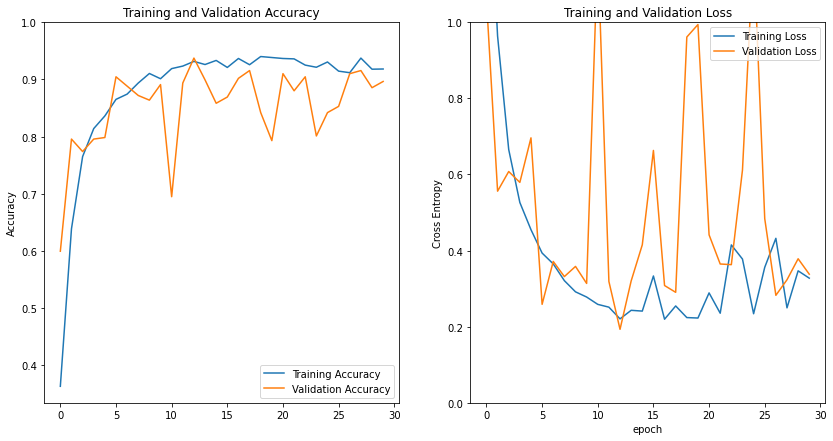

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
loss0, accuracy0 = model.evaluate(test_batches)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 1s 51ms/step - loss: 0.3316 - accuracy: 0.9101
initial loss: 0.33
initial accuracy: 0.91


Valudation Loss의 그래프가 크게 변하는 모습을 보이지만 Test accuracy도 비슷한 것을 보면 Overfit은 아닌것으로 생각된다. 

- Convolutional base의 중간부터 학습하는 방법

In [65]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [66]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [67]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [68]:
base_model.trainable = True

N_FREEZE = 10
for layer in base_model.layers[:N_FREEZE]:
    layer.trainable = False

In [69]:
model = tf.keras.Sequential([
    base_model, 
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [70]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [71]:
EPOCHS = 30  
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/30
92/92 [==============================] - 10s 107ms/step - loss: 1.0693 - accuracy: 0.5960 - val_loss: 0.4158 - val_accuracy: 0.8283
Epoch 2/30
92/92 [==============================] - 10s 106ms/step - loss: 0.5098 - accuracy: 0.8219 - val_loss: 0.4576 - val_accuracy: 0.8065
Epoch 3/30
92/92 [==============================] - 10s 106ms/step - loss: 0.4665 - accuracy: 0.8569 - val_loss: 0.3028 - val_accuracy: 0.8856
Epoch 4/30
92/92 [==============================] - 10s 106ms/step - loss: 0.3401 - accuracy: 0.8825 - val_loss: 0.2994 - val_accuracy: 0.9046
Epoch 5/30
92/92 [==============================] - 10s 106ms/step - loss: 0.2677 - accuracy: 0.9097 - val_loss: 0.3501 - val_accuracy: 0.8801
Epoch 6/30
92/92 [==============================] - 10s 106ms/step - loss: 0.2109 - accuracy: 0.9288 - val_loss: 0.3398 - val_accuracy: 0.9074
Epoch 7/30
92/92 [==============================] - 10s 106ms/step - loss: 0.2685 - accuracy: 0.9278 - val_loss: 0.3730 - val_accuracy: 0.8910

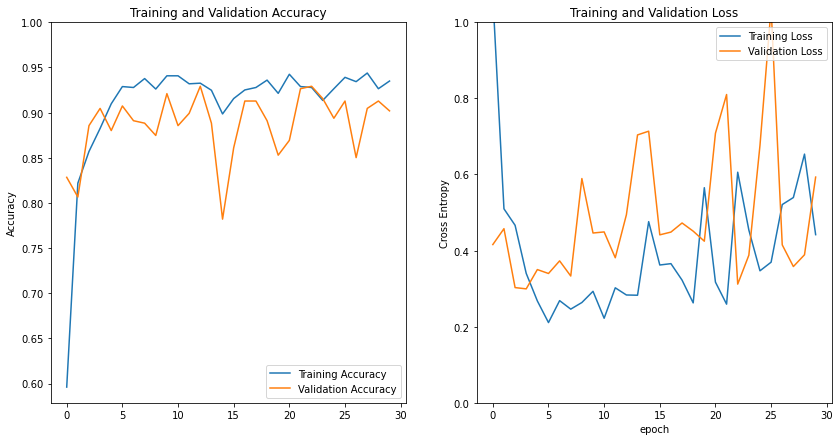

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [73]:
test_steps = 10
loss0, accuracy0 = model.evaluate(test_batches)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 1s 51ms/step - loss: 0.4392 - accuracy: 0.9237
initial loss: 0.44
initial accuracy: 0.92


이 방법으로 학습을 시켰을때 낮은 레벨의 층에서는 ImageNet의 충분한 데이터로 학습후 높은 레벨의 층에서 꽃 이미지를 사용하니 성능의 향상이 있었다. 

#### 2) DenseNet169

In [38]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [39]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False
    
model = tf.keras.Sequential([
base_model, 
global_average_layer,
dense_layer,
prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [40]:
EPOCHS = 11 # epoch를 30을 하였을때 4부터 loss가 급격하게 증가하여 epoch를 3으로 수정
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/11
92/92 [==============================] - 7s 74ms/step - loss: 0.6941 - accuracy: 0.7619 - val_loss: 0.4503 - val_accuracy: 0.8556
Epoch 2/11
92/92 [==============================] - 5s 58ms/step - loss: 0.3451 - accuracy: 0.8835 - val_loss: 0.3805 - val_accuracy: 0.8719
Epoch 3/11
92/92 [==============================] - 5s 59ms/step - loss: 0.2488 - accuracy: 0.9203 - val_loss: 0.3594 - val_accuracy: 0.8692
Epoch 4/11
92/92 [==============================] - 5s 59ms/step - loss: 0.2004 - accuracy: 0.9377 - val_loss: 0.3347 - val_accuracy: 0.8910
Epoch 5/11
92/92 [==============================] - 5s 59ms/step - loss: 0.1570 - accuracy: 0.9554 - val_loss: 0.3373 - val_accuracy: 0.8774
Epoch 6/11
92/92 [==============================] - 5s 59ms/step - loss: 0.1311 - accuracy: 0.9632 - val_loss: 0.3085 - val_accuracy: 0.8910
Epoch 7/11
92/92 [==============================] - 6s 64ms/step - loss: 0.1085 - accuracy: 0.9717 - val_loss: 0.3144 - val_accuracy: 0.8937
Epoch 8/11
92

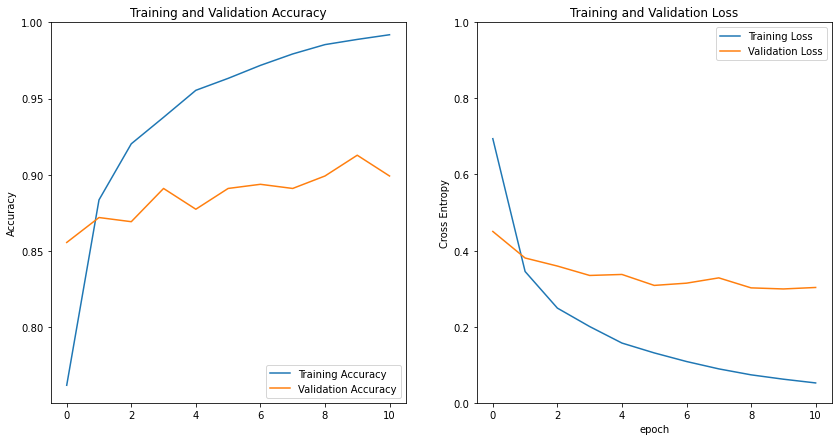

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss0, accuracy0 = model.evaluate(test_batches)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/12 [==============================] - 0s 40ms/step - loss: 0.2261 - accuracy: 0.9264
initial loss: 0.23
initial accuracy: 0.93


### 정리

- VGG16 모델 
    - 테스트1(base_model.trainable = False, base_learning_rate = 0.001, epoch = 32, batch =32)
        - ImageNet 데이터를 사용하여 학습한 Convolutional base의 파라미터는 그대로 사용하고 Classifier만 새로운 데이터로 학습 시키는 전략
        - test accuracy : 0.85
        - 결론
            - 모델의 성능이 떨어짐 : ImageNet 데이터의 label을 확인해보니 daisy는 존재하였지만 다른 꽃들은 포함되어 있지 않아 꽃의 종류를 예측을 하는데 한계가 있다고 생각되어짐 
        - 해결방법
            - 전략 변경 : 새로운 데이터로 처음부터 학습을 수행하는 전략으로 변경 
     
 - 테스트2(base_model.trainable = True, base_learning_rate = 0.001, epoch = 32, batch =32)
     - tf_flower 데이터를 이용하여 모델을 학습 시키는 전략 
     - test accuracy : 0.91
     - 결론
         - 모델의 성능의 향상은 있지만 성능 향상을 위해 epoch를 크게 하는경우 원하는 성능에 도달하기 전에 over fitting이 나타남
         - 데이터의 부족으로 인한 문제로 보여짐
     - 해결방법
         - 전략 변경 : 낮은 레벨의 층에서는 base model의 파라미터를 사용하고 높은 레벨에서는 새로운 데이터로 학습하는 전략으로 변경 

 - 테스트3(base_model.trainable = True, Freeze = 10, base_learning_rate = 0.001, epoch = 32, batch =32)
     - Convolutional base의 중간부터 학습을 수행하는 전략 
     - test accuracy : 0.92
     - 결론 
         - 낮은 레벨에서는 많은 양의 데이터로 이미지들의 형태나 특징들이 학습되고 이미지를 분류하는데 중요한 정보를 가지는 높은 레벨의 층에서는 꽃 이미지를 사용하여 학습을 하니   
           해당 문제를 해결하는데 더 적합한 모델이 만들어 진것으로 보인다 
- DenseNet 모델 
    - 테스트1(base_model.trainable = False, base_learning_rate = 0.001, epoch = 11, batch =32)
        - Classifier만 학습을 수행하는 방법으로 학습 
        - test accuracy : 0.93
        - 결론 
            - 모델의 성능이 더 뛰어나다는 것을 보고 모델을 변경하여 본 결과 VGG16에서 같은 전략을 취했을때보다 많은 성능의 향상을 볼 수 있었다 
            - Epoch를 높게 하는 경우 대략 12Epoch부터는 Valudation Loss 값이 급격하게 증가하였고 따라서 Overfit이 된다는 것을 관찰할 수 있었다. 
            
- 프로젝트를 수행하며 아쉬웠던 점
    - 모델의 특성이나 원리는 잘 알지 못하고 데이터에 적합한 모델을 선정하기 보다는 성능이 좋다는 모델을 무작정 선택하여 테스트를 수행해본 점이 아쉬웠다 
    - 하이퍼 파라미터를 많이 변경하여 보면서 테스트를 수행하여야 하는데 해당 하이퍼 파라미터가 가지는 의미와 이를 변경함으로 생기는 변화에 대한 이해가 부족하다보니 많은 테스트를 수행해보지는 못하였다. 
    - 효율적으로 테스트를 수행하는 방법을 강구할 필요가 있을 것 같다.
    
- Trouble Shooting
    - GPU 메모리 문제 
     
     > tensorflow.python.framework.errors_impl.UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
     - 원인 : Tensorflow는 GPU 메모리를 대부분 매핑하는 문제 
     - 해결 방법 : https://inpages.tistory.com/155